In [27]:
%load_ext griblib.jupyter

from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from numpy.typing import NDArray

import dask
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import Gridliner

DATA = Path.cwd().parent / "data"
PS_STORE = DATA / "PROBSEVERE"
GMGSI_STORE = DATA / "GMGSI"
ONE_HOUR = "1H"
SWP = [
    "CAPE_M10M30",
    "EBSHEAR",
    "FLASH_DENSITY",
    "FLASH_RATE",
    "LJA",
    "MAXLLAZ",
    "MEANWIND_1-3kmAGL",
    "MESH",
    "MLCAPE",
    "MLCIN",
    "MOTION_EAST",
    "MOTION_SOUTH",
    "MUCAPE",
    "P98LLAZ",
    "P98MLAZ",
    "PS",
    "PWAT",
    "SIZE",
    "SRH01KM",
    "VIL_DENSITY",
    "WETBULB_0C_HGT",
]
DIMENSIONS = ["time", "lat", "lon"]
TIME, LAT, LON = DIMENSIONS
idx = pd.IndexSlice

The griblib.jupyter extension is already loaded. To reload it, use:
  %reload_ext griblib.jupyter



    len(times.unique())=5,090
    times.min()=Timestamp('2022-03-01 00:00:00')
    times.max()=Timestamp('2022-09-30 23:00:00')
    

    len(times.unique())=152,553
    times.min()=Timestamp('2022-03-01 00:00:29')
    times.max()=Timestamp('2022-09-30 23:58:41')
    


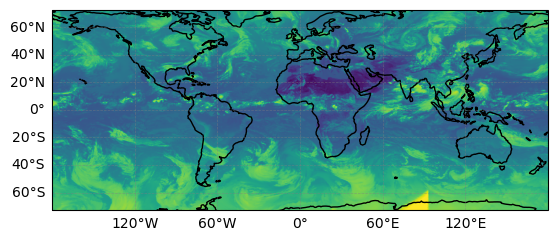

In [28]:
MRMS_BOUNDS = (-130, -60, 20, 55)
W, E, S, N = MRMS_BOUNDS
ref_time = datetime.fromisoformat("2022-07-01T12:00:00")


def mask_time(ds: xr.Dataset) -> xr.Dataset:
    times = pd.to_datetime(ds[TIME].to_numpy())
    print(
        f"""
    {len(times.unique())=:,}
    {times.min()=}
    {times.max()=}
    """
    )
    mask = (
        (times.year == ref_time.year)
        & (times.month == ref_time.month)
        & (times.day == ref_time.day)
        & (times.hour >= 12)
        & (times.hour <= 18)
    )
    return ds.sel({TIME: mask})


def geoaxes(projection=ccrs.PlateCarree()) -> tuple[GeoAxes, Gridliner]:
    ax: GeoAxes = plt.axes(
        projection=projection,
    )
    gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    ax.coastlines(resolution="auto")
    return ax, gl


# open the gmgsi dataset
longwave_ir = mask_time(xr.open_zarr(GMGSI_STORE))
ax, gl = geoaxes()
# select a single parameter and time
longwave_ir_global = longwave_ir["GMGSI_LW"].sel({TIME: np.datetime64(ref_time)})
# define the extent
global_extent = np.array(
    [(longwave_ir_global[crd].min(), longwave_ir_global[crd].max()) for crd in (LON, LAT)]
).flatten()
# plot the image
ax.imshow(longwave_ir_global, extent=global_extent, transform=ccrs.PlateCarree())
# fit the gmgsi dataset into the bounds of the MRMS
longwave_ir = longwave_ir.sel(
    {
        LAT: (longwave_ir.lat > S) & (longwave_ir.lat < N),
        LON: (longwave_ir.lon > W) & (longwave_ir.lon < E),
    }
)
probsevere = xr.open_zarr(PS_STORE)
# probsevere["time"] = probsevere["time"] - np.timedelta64(1, "h")
probsevere = mask_time(probsevere)

In [29]:
def index_min(target: NDArray[np.floating], values: NDArray[np.floating], axis: int = 0) -> NDArray[np.floating]:
    """
    stacks the target and subtracts values to determine the minimum diffrence between 2 misshaped arrays
    the target is index with the absolute minimum diffrence.
    returns an array the same shape as values filled with scaler values from the target
    """
    diff = target[:, np.newaxis] - values
    result = target[abs(diff).argmin(axis=axis)]
    return result


lw_ir = longwave_ir.to_dataframe()
lat, lon = (lw_ir.index.unique(key).to_numpy() for key in (LAT, LON))
# convert the xarray dataset to a pandas dataframe
ps = probsevere.to_dataframe()
# fit the probsevere data to the gmgsi grid
ps[LAT] = index_min(lat, ps["X"].to_numpy())
ps[LON] = index_min(lon, ps["Y"].to_numpy())
# group by time, lat, lon
ps = (
    ps.reset_index()
    .drop(columns=["X", "Y", "MINX", "MINY", "MAXX", "MAXY"])
    .groupby(
        [pd.Grouper(key=TIME, freq=ONE_HOUR, origin="epoch"), LAT, LON],
    )
    .max()
)

df2 = ps.merge(lw_ir, how="outer", left_on=DIMENSIONS, right_on=DIMENSIONS)
df2

CAPE_M10M30    EBSHEAR  \
time                lat       lon                                  
2022-07-01 12:00:00 24.427605 -82.860306        699.0  19.299999   
                              -80.195969        642.0   9.000000   
                    25.081528 -83.652405        614.0  19.100000   
                    25.277023 -82.500259        733.0  13.200000   
                    25.537201 -82.716286        682.0  13.500000   
...                                               ...        ...   
2022-07-01 18:00:00 54.983643 -60.321495          NaN        NaN   
                              -60.249489          NaN        NaN   
                              -60.177479          NaN        NaN   
                              -60.105469          NaN        NaN   
                              -60.033459          NaN        NaN   

                                          FLASH_DENSITY  FLASH_RATE        ID  \
time                lat       lon                                               
2022-07-01 12:00:00 24.427605 -82.860306            0.0         0.0  120984.0   
                              -80.195969            0.0         0.0  121168.0   
                    25.081528 -83.652405            0.0         0.0  121219.0   
                    25.277023 -82.500259            0.0         0.0  121218.0   
                    25.537201 -82.716286            0.0         0.0  121144.0   
...                                                 ...         ...       ...   
2022-07-01 18:00:00 54.983643 -60.321495            NaN         NaN       NaN   
                              -60.249489            NaN         NaN       NaN   
                              -60.177479            NaN         NaN       NaN   
                              -60.105469            NaN         NaN       NaN   
                              -60.033459            NaN         NaN       NaN   

                                          LJA  MAXLLAZ  MEANWIND_1-3kmAGL  \
time                lat       lon                                           
2022-07-01 12:00:00 24.427605 -82.860306  0.0    0.001               16.0   
                              -80.195969  0.0    0.001               14.4   
                    25.081528 -83.652405  0.0    0.001               13.8   
                    25.277023 -82.500259  0.0    0.000               14.0   
                    25.537201 -82.716286  0.0    0.001               13.4   
...                                       ...      ...                ...   
2022-07-01 18:00:00 54.983643 -60.321495  NaN      NaN                NaN   
                              -60.249489  NaN      NaN                NaN   
                              -60.177479  NaN      NaN                NaN   
                              -60.105469  NaN      NaN                NaN   
                              -60.033459  NaN      NaN                NaN   

                                          MESH  MLCAPE  ...  MUCAPE  P98LLAZ  \
time                lat       lon                       ...                    
2022-07-01 12:00:00 24.427605 -82.860306  0.00  2524.0  ...  3160.0    0.001   
                              -80.195969  0.00  2437.0  ...  3099.0    0.001   
                    25.081528 -83.652405  0.00  2168.0  ...  3005.0    0.001   
                    25.277023 -82.500259  0.00  2779.0  ...  3453.0    0.000   
                    25.537201 -82.716286  0.05  2629.0  ...  3122.0    0.001   
...                                        ...     ...  ...     ...      ...   
2022-07-01 18:00:00 54.983643 -60.321495   NaN     NaN  ...     NaN      NaN   
                              -60.249489   NaN     NaN  ...     NaN      NaN   
                              -60.177479   NaN     NaN  ...     NaN      NaN   
                              -60.105469   NaN     NaN  ...     NaN      NaN   
                              -60.033459   NaN     NaN  ...     NaN      NaN   

                                          P98MLAZ   PS  PWAT

In [30]:
print(df2.columns)

Index(['CAPE_M10M30', 'EBSHEAR', 'FLASH_DENSITY', 'FLASH_RATE', 'ID', 'LJA',
       'MAXLLAZ', 'MEANWIND_1-3kmAGL', 'MESH', 'MLCAPE', 'MLCIN',
       'MOTION_EAST', 'MOTION_SOUTH', 'MUCAPE', 'P98LLAZ', 'P98MLAZ', 'PS',
       'PWAT', 'SIZE', 'SRH01KM', 'VIL_DENSITY', 'WETBULB_0C_HGT', 'GMGSI_LW'],
      dtype='object')


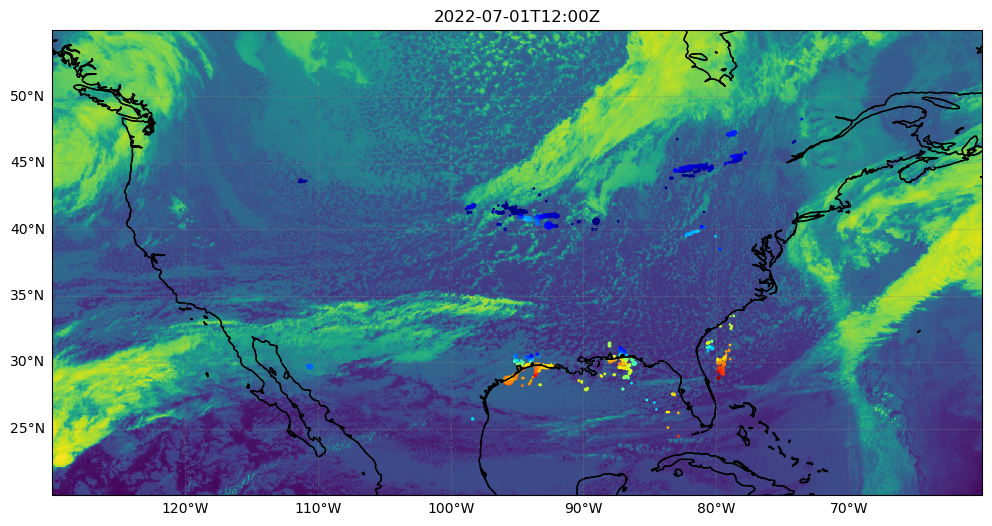

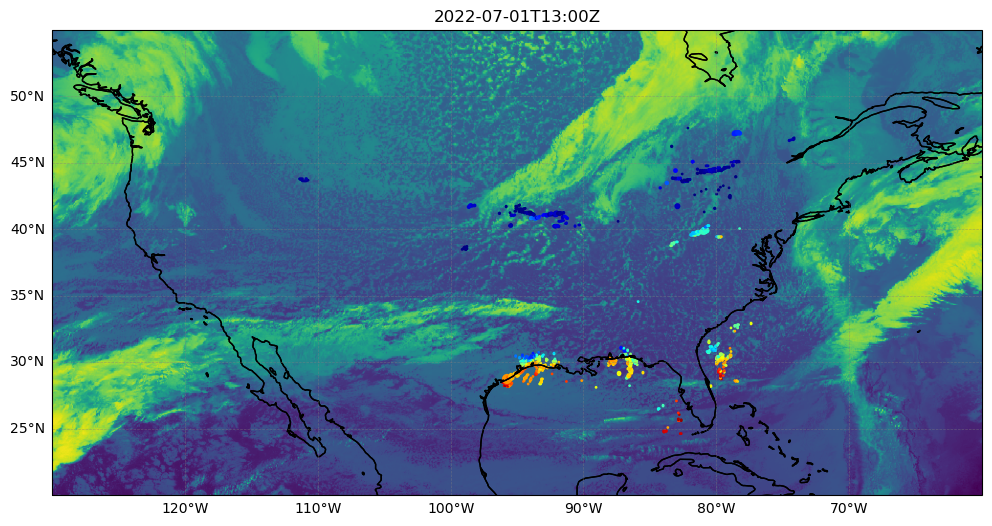

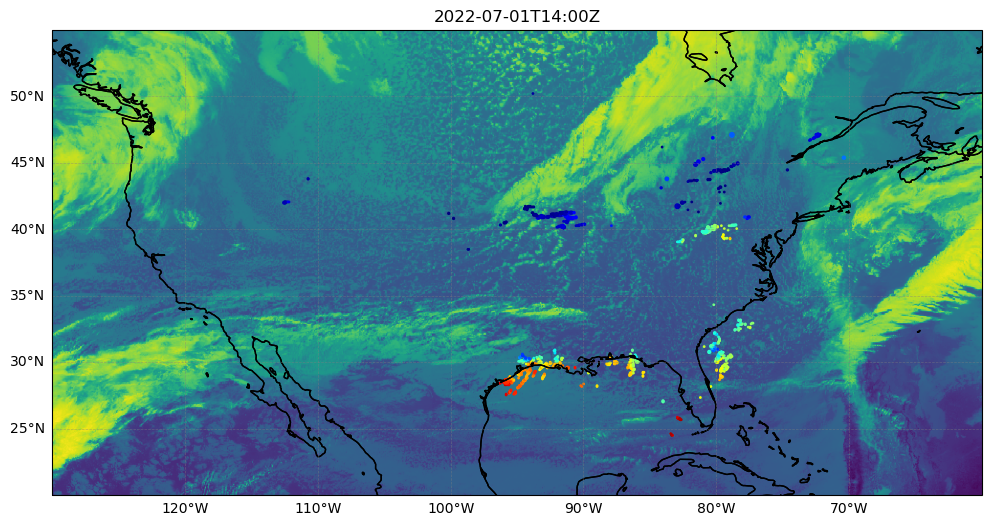

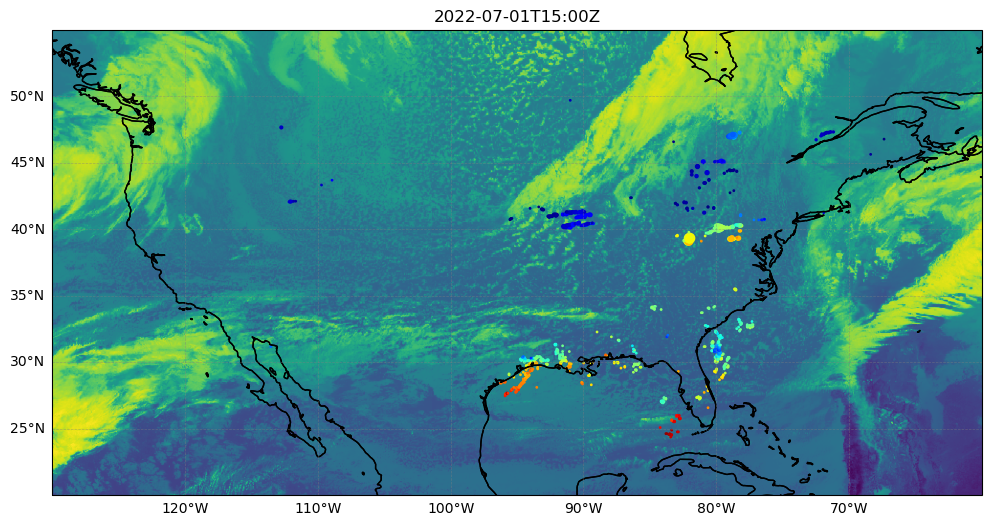

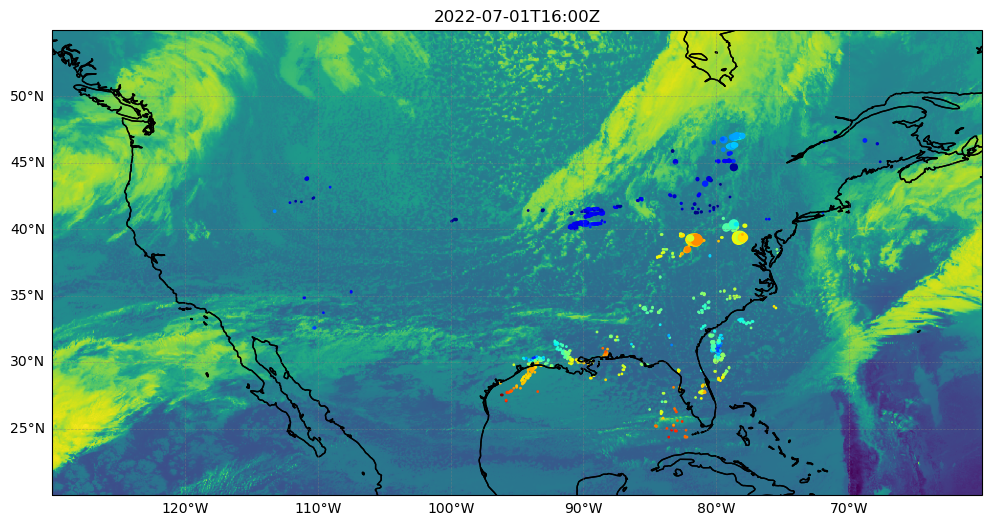

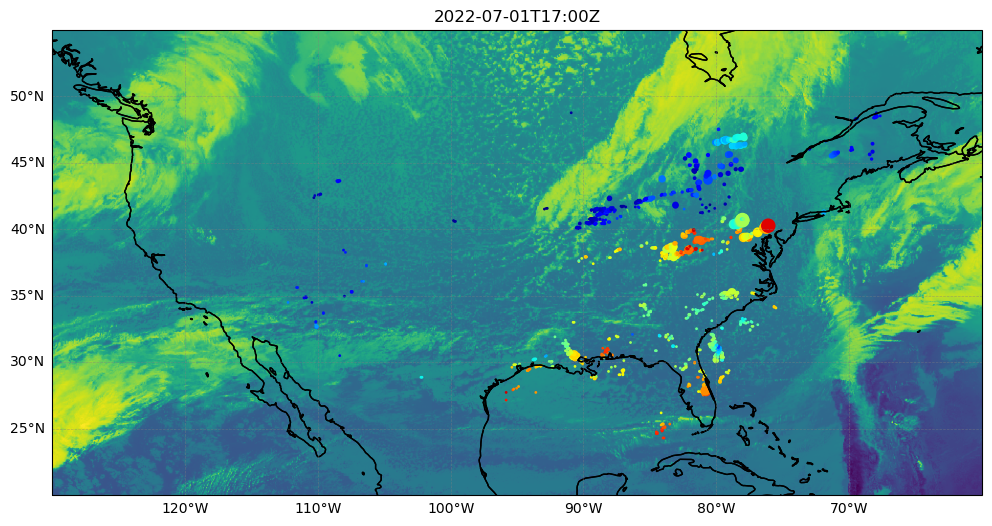

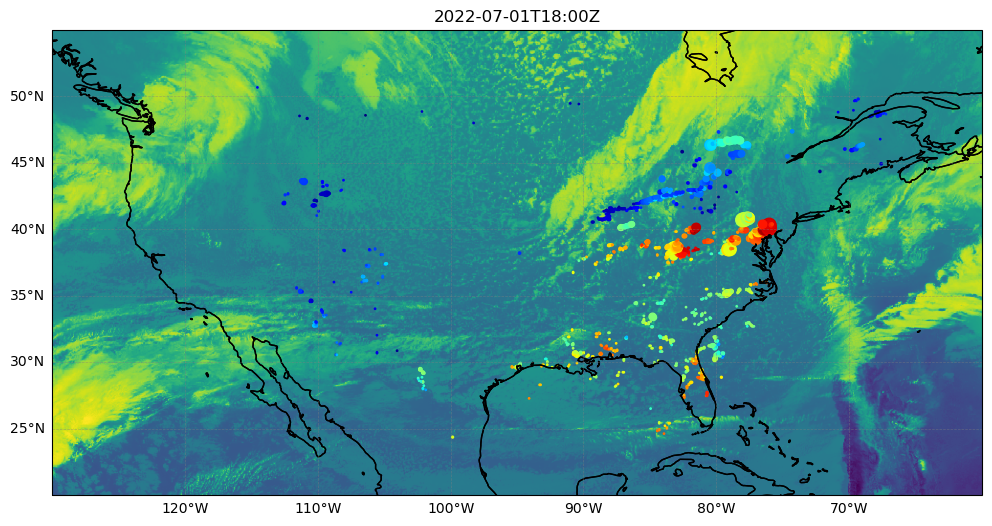

In [31]:
for label, frame in df2.groupby("time"):
    fig = plt.figure(label.timestamp(), figsize=(12, 18))
    ax, gl = geoaxes()

    ax.set_title(label.strftime("%Y-%m-%dT%H:%MZ"))
    ax.coastlines(resolution="auto")
    ax.imshow(frame["GMGSI_LW"].unstack(LON), extent=MRMS_BOUNDS, origin="lower", transform=ccrs.PlateCarree())
    frame.reset_index().plot.scatter(
        x=LON,
        y=LAT,
        s="PS",
        c="MLCAPE",
        ax=ax,
        fig=fig,
        cmap="jet",
        transform=ccrs.PlateCarree(),
        colorbar=False,
    )

Index(['CAPE_M10M30', 'EBSHEAR', 'FLASH_DENSITY', 'FLASH_RATE', 'ID', 'LJA',
       'MAXLLAZ', 'MEANWIND_1-3kmAGL', 'MESH', 'MLCAPE', 'MLCIN',
       'MOTION_EAST', 'MOTION_SOUTH', 'MUCAPE', 'P98LLAZ', 'P98MLAZ', 'PS',
       'PWAT', 'SIZE', 'SRH01KM', 'VIL_DENSITY', 'WETBULB_0C_HGT', 'GMGSI_LW'],
      dtype='object')

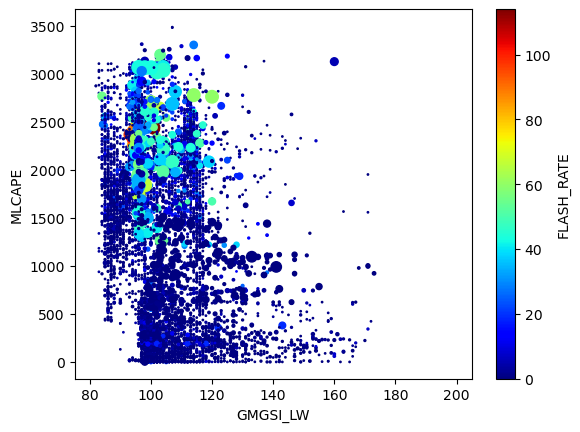

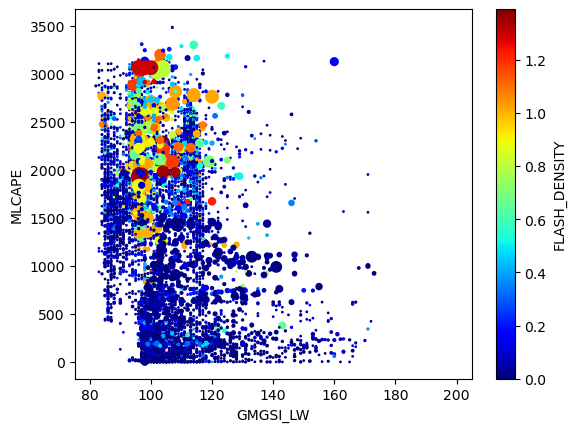

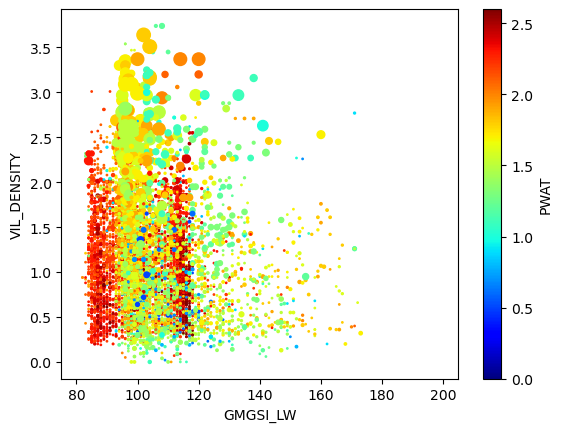

In [32]:
with_ps = df2.loc[df2.notna().all(axis=1), :]
with_ps.plot.scatter("GMGSI_LW", "MLCAPE", c="FLASH_RATE", s="PS", cmap="jet")
with_ps.plot.scatter("GMGSI_LW", "MLCAPE", c="FLASH_DENSITY", s="PS", cmap="jet")
with_ps.plot.scatter("GMGSI_LW", "VIL_DENSITY", c="PWAT", s="PS", cmap="jet")
with_ps.columns

<AxesSubplot: xlabel='GMGSI_LW', ylabel='VIL_DENSITY'>

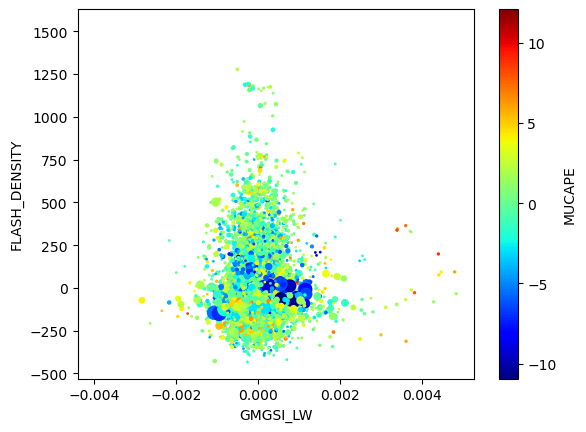

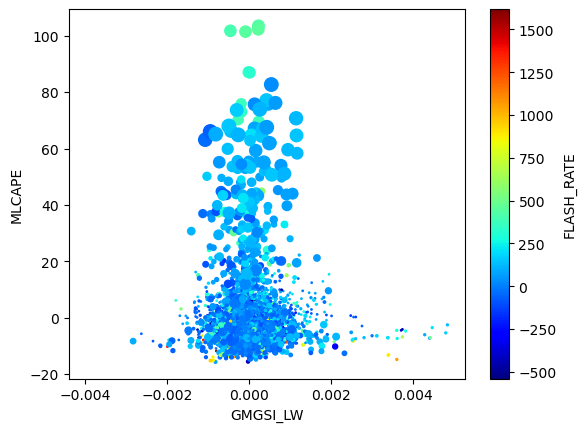

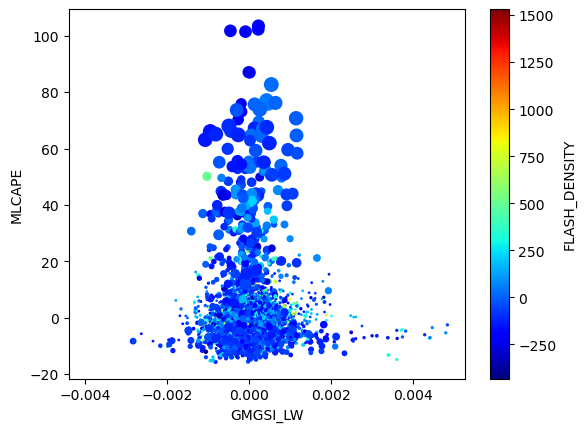

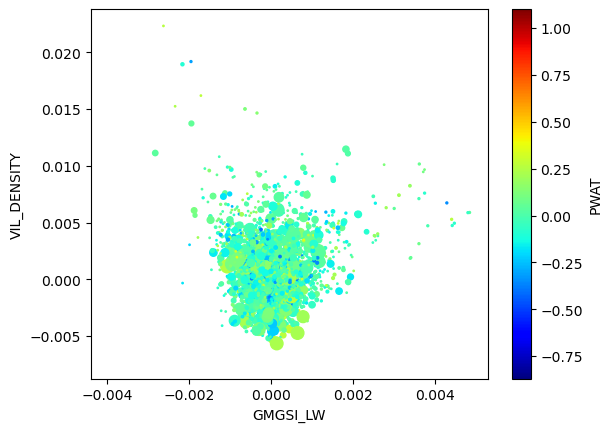

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(df2.columns))
df3 = pd.DataFrame(pca.fit_transform(with_ps, df2), columns=df2.columns)
df3.plot.scatter("GMGSI_LW", "FLASH_DENSITY", c="MUCAPE", s=with_ps["PS"], cmap="jet")
df3.plot.scatter("GMGSI_LW", "MLCAPE", c="FLASH_RATE", s=with_ps["PS"], cmap="jet")
df3.plot.scatter("GMGSI_LW", "MLCAPE", c="FLASH_DENSITY", s=with_ps["PS"], cmap="jet")
df3.plot.scatter("GMGSI_LW", "VIL_DENSITY", c="PWAT", s=with_ps["PS"], cmap="jet")